In [11]:
import cv2
import os
import numpy as np 
import pandas as pd 
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import DataLoader
from PytorchWildlife.models import detection as pw_detection
from PytorchWildlife.data import transforms as pw_trans
from PytorchWildlife.data import datasets as pw_data 
from PytorchWildlife import utils as pw_utils
%matplotlib inline
from random import randint

# Import Data Science Libraries

import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [12]:
dir = 'data/Set1'
folders = ['data/Set1/{}'.format(i) for i in os.listdir(dir)]
folders.remove('data/Set1/.DS_Store')
folders.remove('data/Set1/labels.txt')
folders.remove('data/Set1/README.txt')

In [13]:
folders_seq = []

for folder in folders:
    for i in os.listdir(folder):
        temp_folder = folder+'/'+i.format(i)
        folders_seq.append(temp_folder)

In [14]:
# folders_seq

In [15]:

crop_output_folder = []
for folder in folders_seq:
    if '.DS_Store' not in folder:
        for i in os.listdir(folder):
            if i == 'crop_output':    
                temp_folder = folder+'/'+i.format(i)
                crop_output_folder.append(temp_folder)

In [16]:
img_data = []
for folder in crop_output_folder:
    if '.DS_Store' not in folder:
        for i in os.listdir(folder):
            # print(i)
            temp_folder = folder+'/'+i.format(i)
            img_data.append(temp_folder)

In [18]:
def extract_substring(path):
    start_marker = 'data/Set1/'

    start_pos = path.find(start_marker) + len(start_marker)

    end_pos = path.find('/', start_pos)

    return path[start_pos:end_pos]

In [19]:
labels = [extract_substring(i) for i in img_data]
# print(len(labels))
labels = [item.split('-', 1)[1] for item in labels]
# print(len(img_data))

In [21]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [22]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for github notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [23]:
image_df = pd.DataFrame({'Filepath': img_data, 'Label': labels})

/var/folders/r0/75rvz7792qg8r39qryvm8b1m0000gn/T/ipykernel_46971/3153923292.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
/var/folders/r0/75rvz7792qg8r39qryvm8b1m0000gn/T/ipykernel_46971/3153923292.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(label_counts.index, rotation=45)


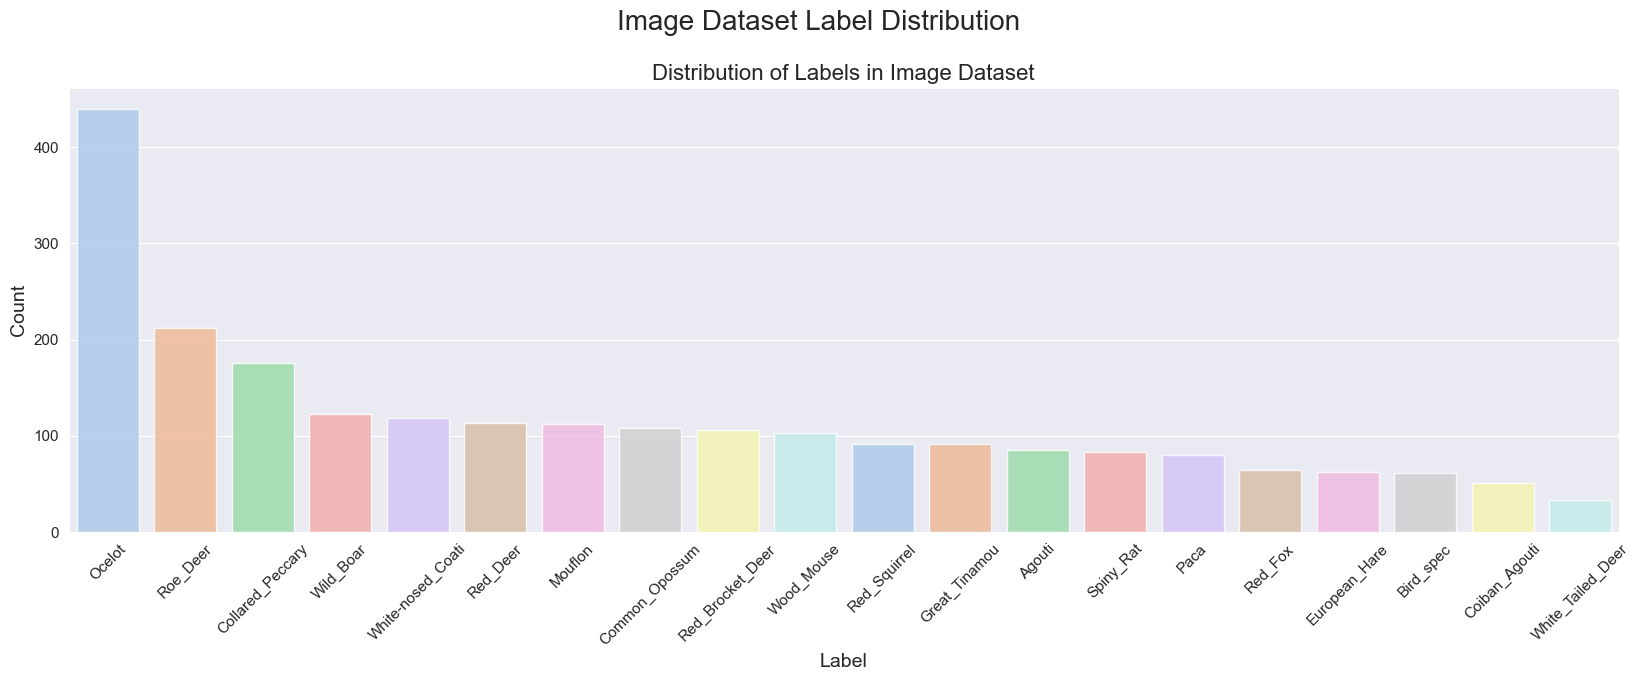

In [24]:
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

In [25]:
## removing 230 Ocelot images 
image_list= [item for item in img_data if 'Ocelot' in item]
# print(len(image_list))

randomly_removed_images = random.sample(image_list, 230)
for image in randomly_removed_images:
    img_data.remove(image)
# print(len(image_list))

440
440


In [26]:
### Restructuring Labels
labels = [extract_substring(i) for i in img_data]

labels = [item.split('-', 1)[1] for item in labels]

image_df = pd.DataFrame({'Filepath': img_data, 'Label': labels})

In [2]:
### Reading text file with box notation

In [28]:
def parse_file_to_dict(file_path):
    data_dict = {}    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()  # Split by whitespace
            if len(parts) < 2:  # Check for minimum length
                continue
            path = parts[0]  # First part is the path
            num_boxes = int(parts[1])  # Second part is the number of bounding boxes
            # Extract bounding boxes
            boxes = []
            for i in range(num_boxes):
                box_start = 2 + i * 4  # Each box has 4 values (xmin, ymin, xmax, ymax)
                box = tuple(map(int, parts[box_start:box_start + 4]))
                boxes.append(box)
            # Add to dictionary
            data_dict[path] = boxes
    return data_dict


file_path = 'data/Set1/labels.txt'  # Replace with your actual file path
bounding_boxes_dict = parse_file_to_dict(file_path)


bounding_boxes_dict
one_animal_list = []
for key  in bounding_boxes_dict:
    if len(bounding_boxes_dict[key]) == 1:
        one_animal_list.append(key)

for i in range(len(one_animal_list)):    
    start_marker = 'data/Set1/'
    image_path = one_animal_list[i]   
    one_animal_list[i] = start_marker+image_path
  

In [29]:
def format_strings(input_string):
    
    last_img_index = input_string.rfind('IMG')
    

    last_img_index = input_string.rfind('IMG')

    # Check if there's an underscore "_" immediately after 'IMG'
    if last_img_index != -1 and len(input_string) > last_img_index + 3 and input_string[last_img_index + 3] == '_':
        new_string = input_string  # If there's already an underscore, do nothing
    else:
        # If there's no underscore, insert one
        new_string = input_string[:last_img_index + 3] + '_' + input_string[last_img_index + 3:]

    return new_string

def fix_folder_name(input_string):
    new_string = input_string.replace('1.07-Red_Deer', '1.07-Red_Brocket_Deer')
    return new_string

In [30]:
one_animal_list = [format_strings(i) for i in one_animal_list]


In [31]:
one_animal_list = [fix_folder_name(i) for i in one_animal_list]


In [32]:
def check_image_exist(file_path):
    if os.path.exists(file_path):
        pass
    else:
        print(f"The file path '{file_path}' does not exist.")
    return file_path
not_available = [check_image_exist(i) for i in one_animal_list]

In [33]:
labels = [extract_substring(i) for i in one_animal_list]
labels = [item.split('-', 1)[1] for item in labels]


#### Replotting Label Distribution

/var/folders/r0/75rvz7792qg8r39qryvm8b1m0000gn/T/ipykernel_46971/3153923292.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
/var/folders/r0/75rvz7792qg8r39qryvm8b1m0000gn/T/ipykernel_46971/3153923292.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(label_counts.index, rotation=45)


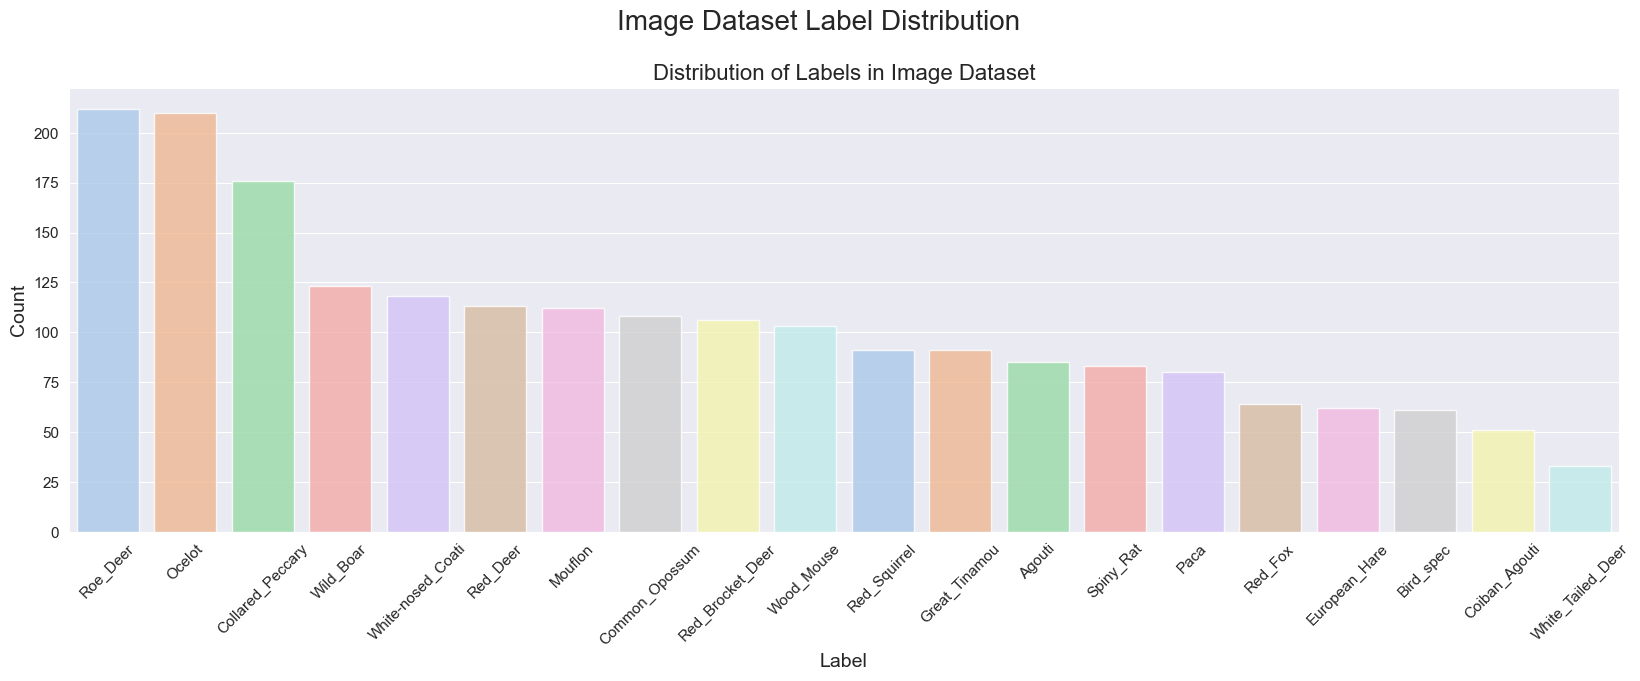

In [37]:
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

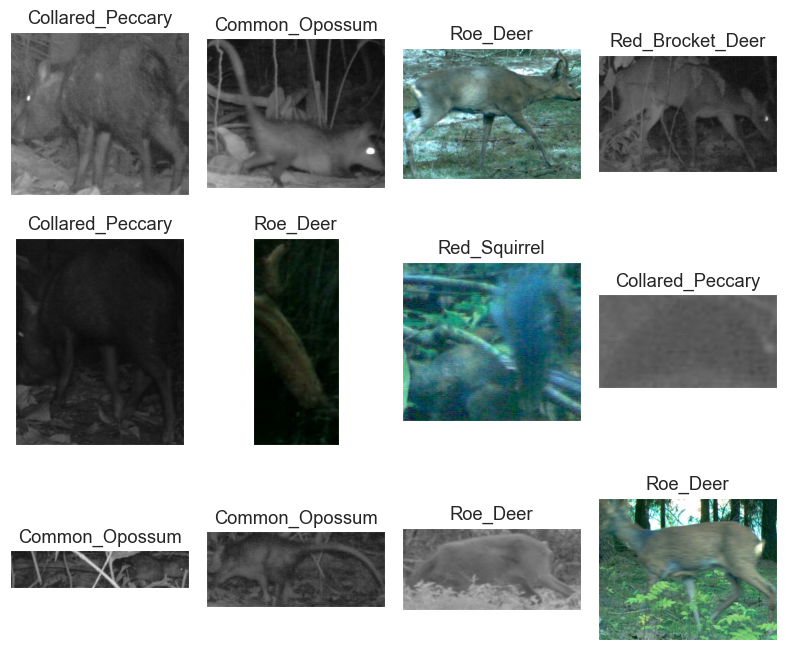

In [43]:
random_index = np.random.randint(0, len(image_df), 12)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [30]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

In [1]:
# # View random sample from the dataset
# # p = random_sample('data/Set1/1.10-Ocelot/SEQ91744/crop_output')
# p = 'data/Set1/1.10-Ocelot/SEQ91744/crop_output/0_0_SEQ91744_IMG_0002.JPG'
# orig = cv2.imread(p)
# orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
# init_val = 100
# columns = 3
# rows = 3

# fig=plt.figure(figsize=(15, 10))
# for i in range(1, columns*rows +1):
#     quality=init_val - (i-1) * 8
#     img = compute_ela_cv(path=p, quality=quality)
#     if i == 1:
#         img = orig.copy()
#     ax = fig.add_subplot(rows, columns, i) 
#     ax.title.set_text(f'q: {quality}')
#     plt.imshow(img)
# plt.show()

### Splitting Training and Testing of data

In [33]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [34]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [35]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    # target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    # batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    # target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    # batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    # target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    # batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1332 validated image filenames belonging to 20 classes.
Found 333 validated image filenames belonging to 20 classes.
Found 417 validated image filenames belonging to 20 classes.


In [36]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [37]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [38]:
checkpoint_path = "animals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [39]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(20, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/animals_classification/20231130-122036
Epoch 1/50
42/42 [==============================] - 2296s 55s/step - loss: 4.5148 - accuracy: 0.0548 - val_loss: 3.5998 - val_accuracy: 0.0270 - lr: 1.0000e-05
Epoch 2/50
42/42 [==============================] - 1219s 29s/step - loss: 4.3646 - accuracy: 0.0511 - val_loss: 3.3585 - val_accuracy: 0.0270 - lr: 1.0000e-05
Epoch 3/50
42/42 [==============================] - 1186s 28s/step - loss: 4.2013 - accuracy: 0.0691 - val_loss: 3.2458 - val_accuracy: 0.0450 - lr: 1.0000e-05
Epoch 4/50
42/42 [==============================] - 1180s 28s/step - loss: 4.2065 - accuracy: 0.0638 - val_loss: 3.1695 - val_accuracy: 0.0781 - lr: 1.0000e-05
Epoch 5/50
42/42 [==============================] - 1186s 28s/step - loss: 4.1441 - accuracy: 0.0616 - val_loss: 3.1051 - val_accuracy: 0.1021 - lr: 1.0000e-05
Epoch 6/50
42/42 [==============================] - 1185s 29s/step - loss: 4.1545 - accuracy: 0.0743 - val_loss: 3

In [41]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.81545
Test Accuracy: 50.60%


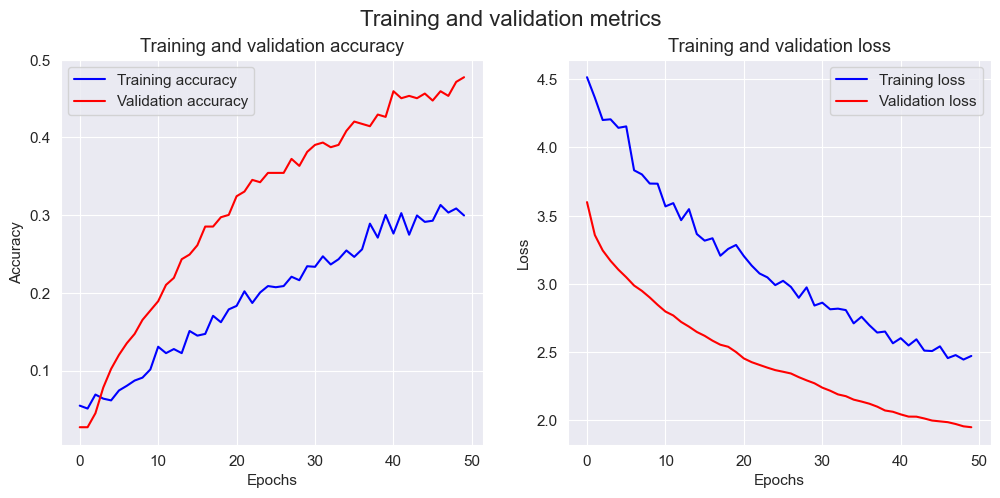

In [42]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [49]:
from joblib import Parallel, delayed 
import joblib 


# Save the model as a pickle in a file 
joblib.dump(model, 'wildlife_model.pkl') 





In [3]:
## Saving Model into Pickle

In [51]:

# Load the model from the file 
NetB7_from_joblib = joblib.load('wildlife_model.pkl') 
NetB7_from_joblib
# Use the loaded model to make predictions 
# knn_from_joblib.predict(X_test) 

In [56]:
#### Temp code get rid of it laterrrrrrr
# test_images[0]
test_pred = model.predict(test_images)
pred = np.argmax(test_pred,axis=1)


14/14 [==============================] - 346s 24s/step


In [58]:
#### Temp code get rid of it laterrrrrrr
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Red_Brocket_Deer', 'Agouti', 'Great_Tinamou', 'Ocelot', 'White-nosed_Coati']


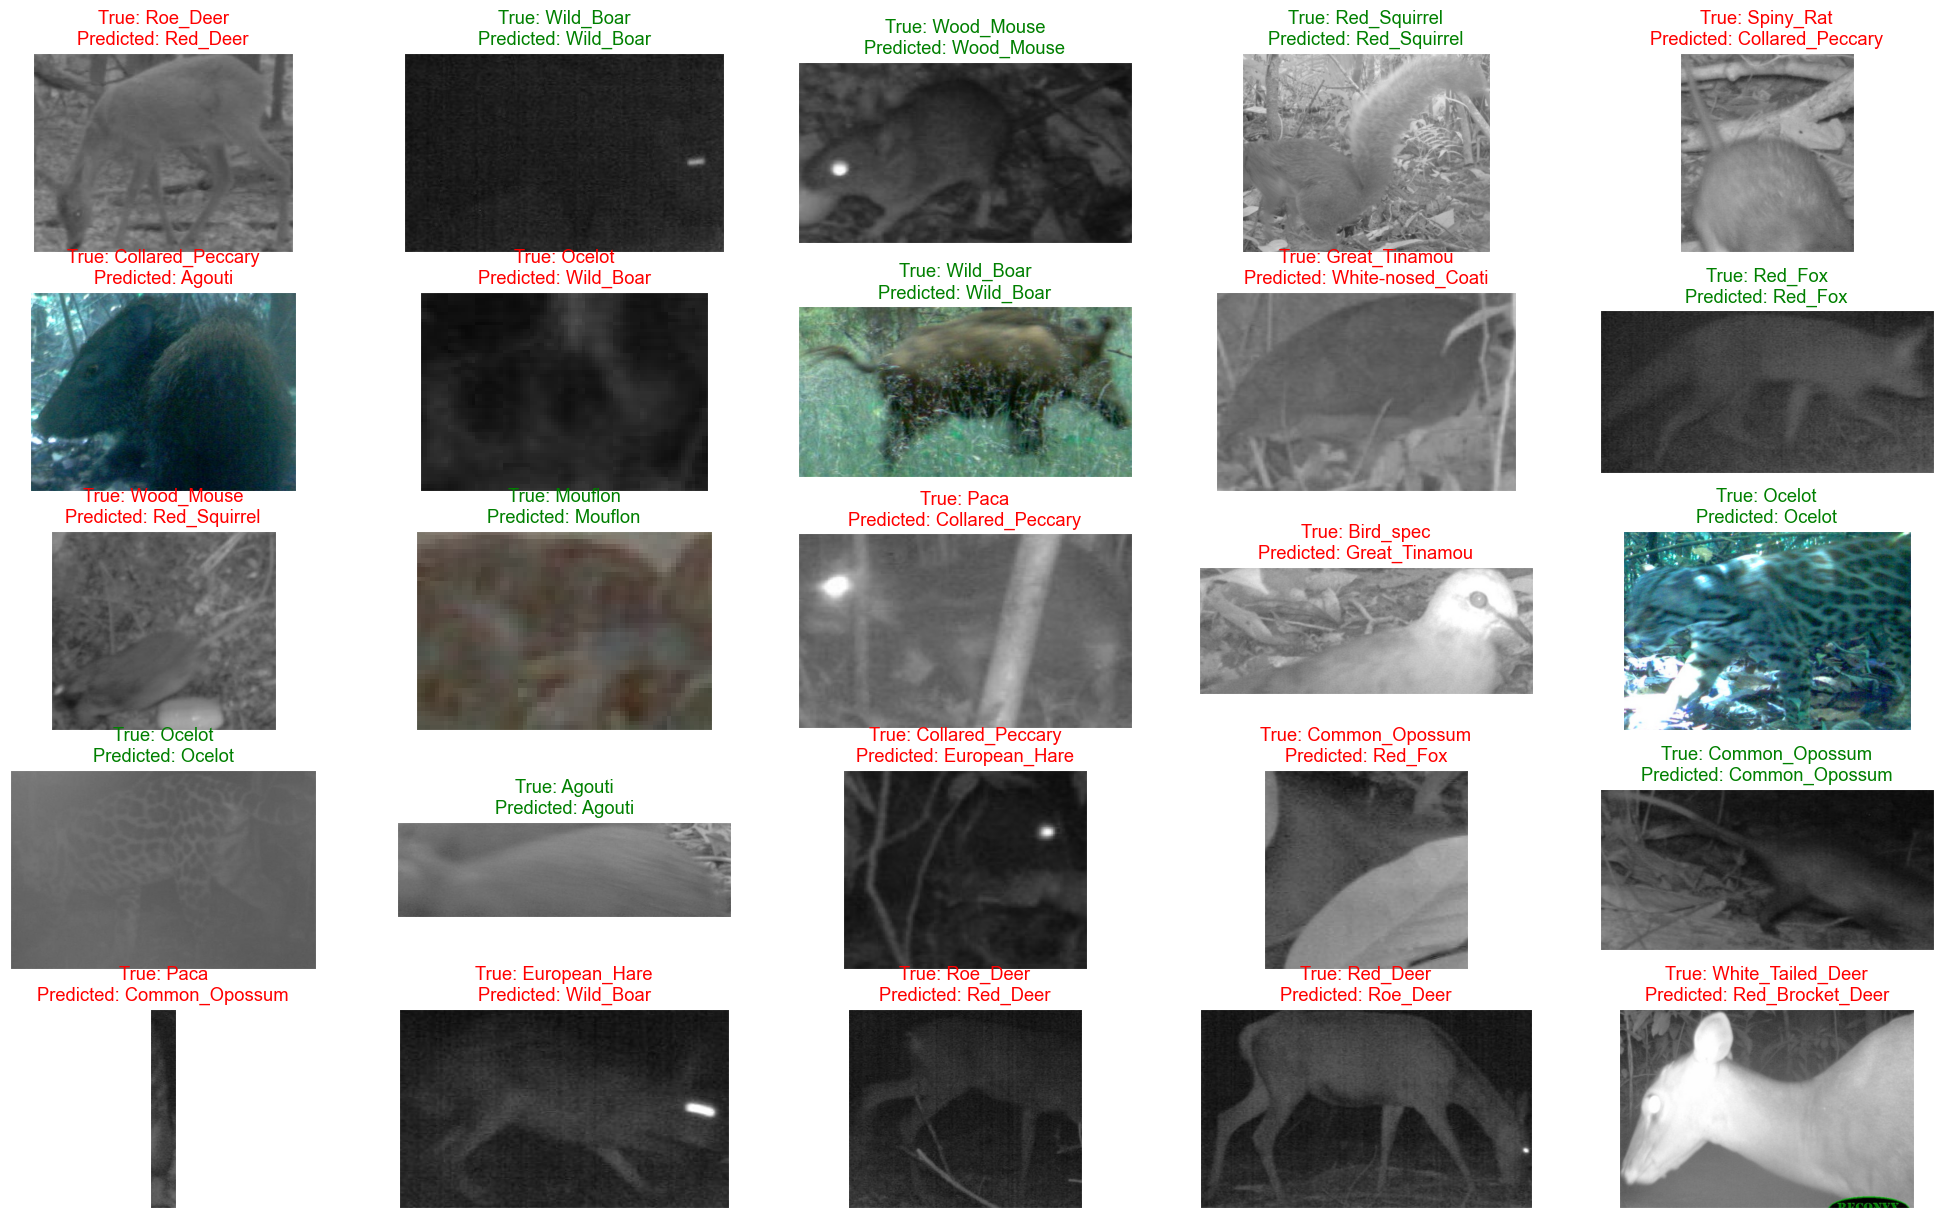

<Figure size 640x480 with 0 Axes>

In [59]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 30)
pred_red = 0
pred_green = 0
tot_reset = 5
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:        
        color = "red"                
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [44]:
############ code ends here #########

In [43]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

14/14 [==============================] - 323s 22s/step
The first 5 predictions: ['Red_Brocket_Deer', 'Agouti', 'Great_Tinamou', 'Ocelot', 'White-nosed_Coati']


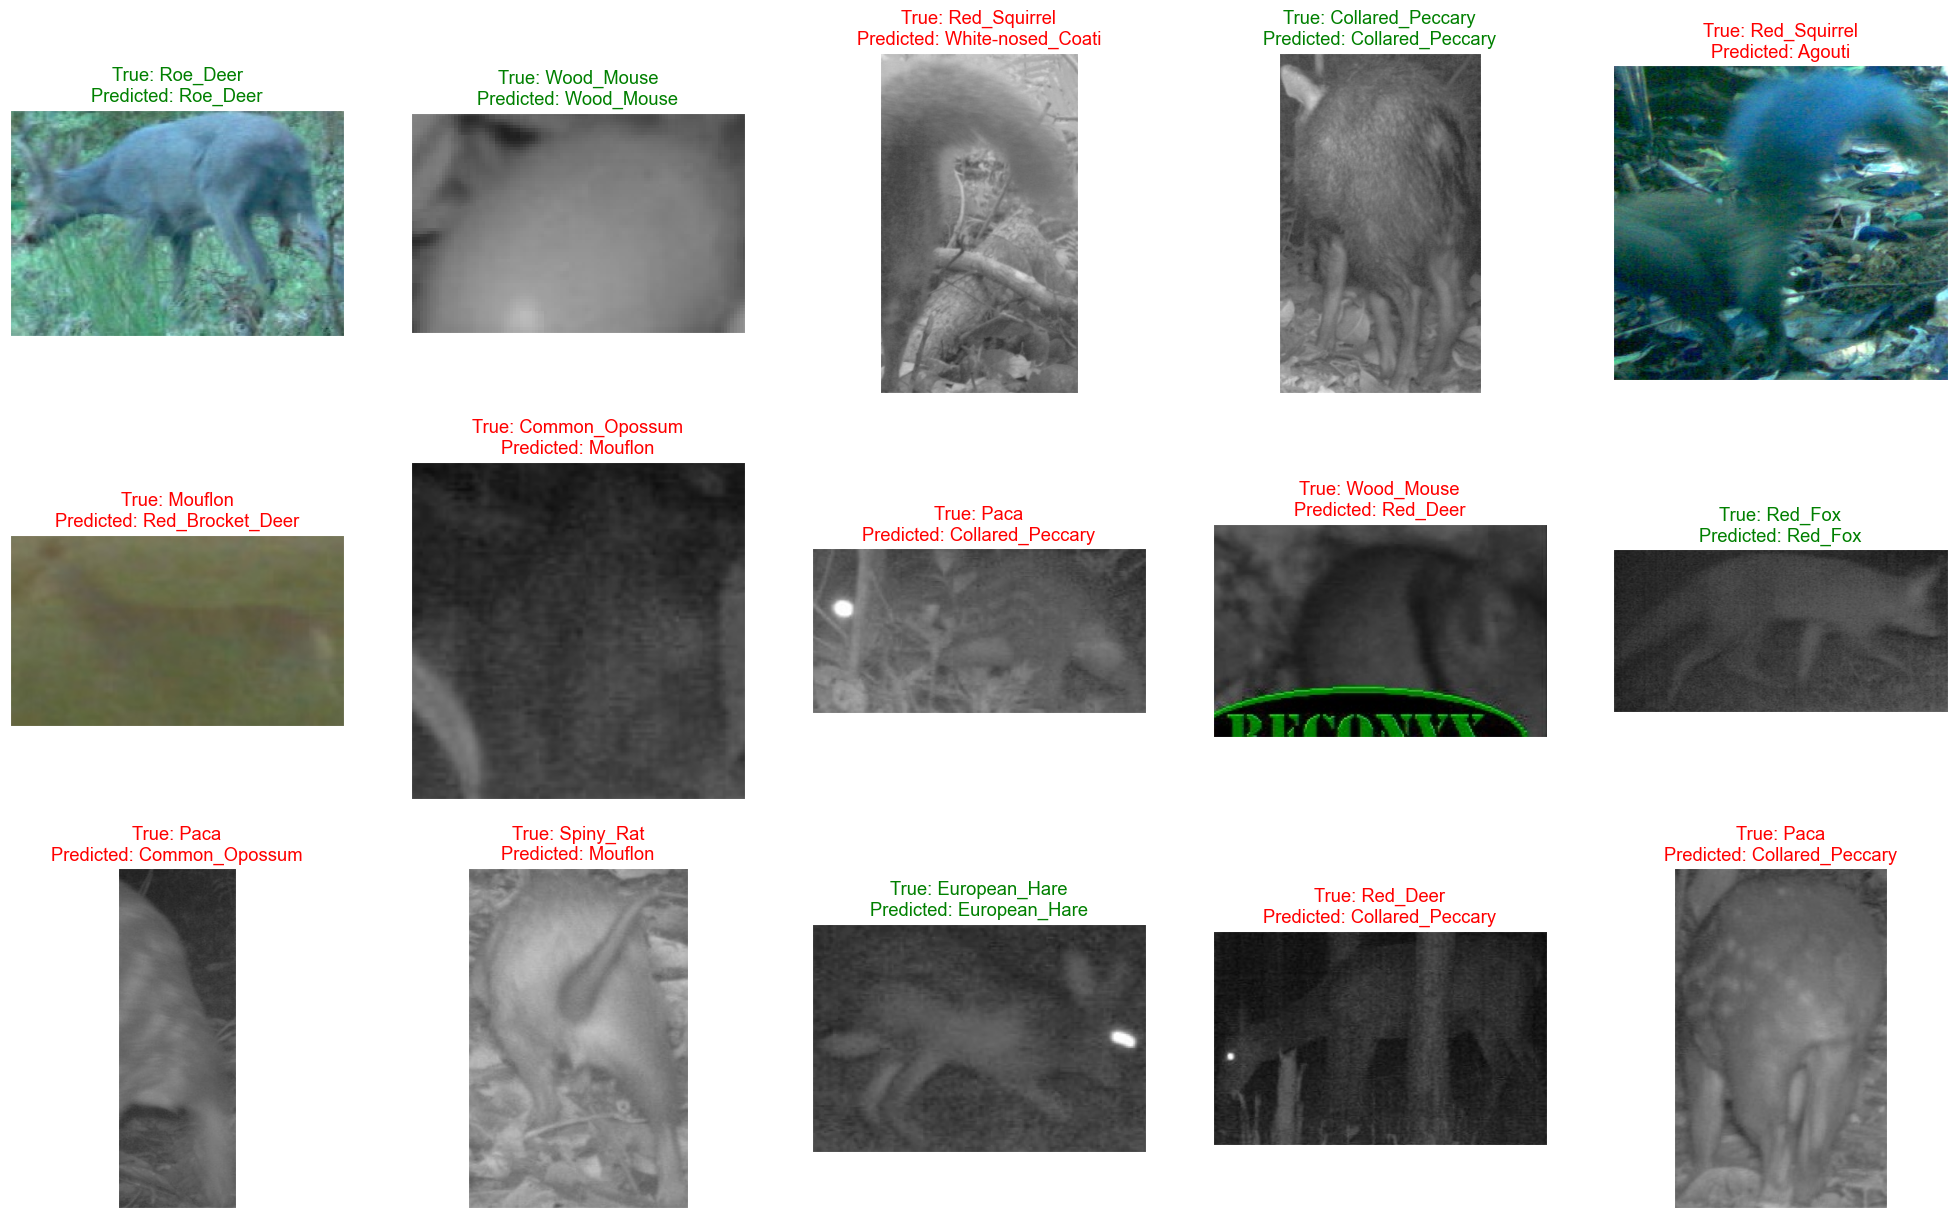

<Figure size 640x480 with 0 Axes>

In [44]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 30)
pred_red = 0
pred_green = 0
tot_reset = 5
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:        
        color = "green"        
    else:        
        color = "red"        
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

array([224, 202,  47, 192, 129, 189, 401, 251,  32, 376,  36, 298,  51, 327, 252])

In [60]:
# test_df.Filepath.iloc[random_index[51]]

Filepath             Label
1366  data/Set1/1.63-European_Hare/SEQ75204/crop_out...     European_Hare
807   data/Set1/1.19-Common_Opossum/SEQ76195/crop_ou...    Common_Opossum
1514  data/Set1/1.25-Great_Tinamou/SEQ75977/crop_out...     Great_Tinamou
29    data/Set1/1.10-Ocelot/SEQ83782/crop_output/0_0...            Ocelot
532   data/Set1/1.09-Spiny_Rat/SEQ83441/crop_output/...         Spiny_Rat
...                                                 ...               ...
168   data/Set1/1.10-Ocelot/SEQ92237/crop_output/0_0...            Ocelot
303   data/Set1/1.77-Wood_Mouse/SEQ78282/crop_output...        Wood_Mouse
986   data/Set1/1.03-Collared_Peccary/SEQ84581/crop_...  Collared_Peccary
1999  data/Set1/1.59-Wild_Boar/SEQ76400/crop_output/...         Wild_Boar
352   data/Set1/1.58-Roe_Deer/SEQ83218/crop_output/0...          Roe_Deer

[417 rows x 2 columns]

In [ ]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 30)
pred_red = 0
pred_green = 0
tot_reset = 5
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
        color = "green"
        ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
        
    else:
        ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
        color = "red"
        ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
        
    # ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [61]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                   precision    recall  f1-score   support

           Agouti       0.18      0.29      0.22        14
        Bird_spec       0.64      0.47      0.54        15
    Coiban_Agouti       0.00      0.00      0.00         6
 Collared_Peccary       0.38      0.50      0.43        34
   Common_Opossum       0.45      0.23      0.30        22
    European_Hare       0.35      0.47      0.40        15
    Great_Tinamou       0.75      0.30      0.43        20
          Mouflon       0.59      0.83      0.69        29
           Ocelot       0.67      0.71      0.69        41
             Paca       0.25      0.06      0.10        16
 Red_Brocket_Deer       0.38      0.63      0.47        19
         Red_Deer       0.44      0.44      0.44        18
          Red_Fox       0.57      0.50      0.53         8
     Red_Squirrel       0.35      0.41      0.38        17
         Roe_Deer       0.77      0.67      0.72        49
        Spiny_Rat       0.67      0.10      0.17       

In [62]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Agouti              0.181818  0.285714  0.222222   14.000000
Bird_spec           0.636364  0.466667  0.538462   15.000000
Coiban_Agouti       0.000000  0.000000  0.000000    6.000000
Collared_Peccary    0.377778  0.500000  0.430380   34.000000
Common_Opossum      0.454545  0.227273  0.303030   22.000000
European_Hare       0.350000  0.466667  0.400000   15.000000
Great_Tinamou       0.750000  0.300000  0.428571   20.000000
Mouflon             0.585366  0.827586  0.685714   29.000000
Ocelot              0.674419  0.707317  0.690476   41.000000
Paca                0.250000  0.062500  0.100000   16.000000
Red_Brocket_Deer    0.375000  0.631579  0.470588   19.000000
Red_Deer            0.444444  0.444444  0.444444   18.000000
Red_Fox             0.571429  0.500000  0.533333    8.000000
Red_Squirrel        0.350000  0.411765  0.378378   17.000000
Roe_Deer            0.767442  0.673469  0.717391   49.000000
Spiny_Rat           0.666667  0.100000  0.173913   20.000000
White-nosed_Coati   0.470588  0.761905  0.581818   21.000000
White_Tailed_Deer   0.000000  0.000000  0.000000    5.000000
Wild_Boar           0.500000  0.409091  0.450000   22.000000
Wood_Mouse          0.645161  0.769231  0.701754   26.000000
accuracy            0.505995  0.505995  0.505995    0.505995
macro avg           0.452551  0.427260  0.412524  417.000000
weighted avg        0.522909  0.505995  0.487983  417.000000

In [64]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

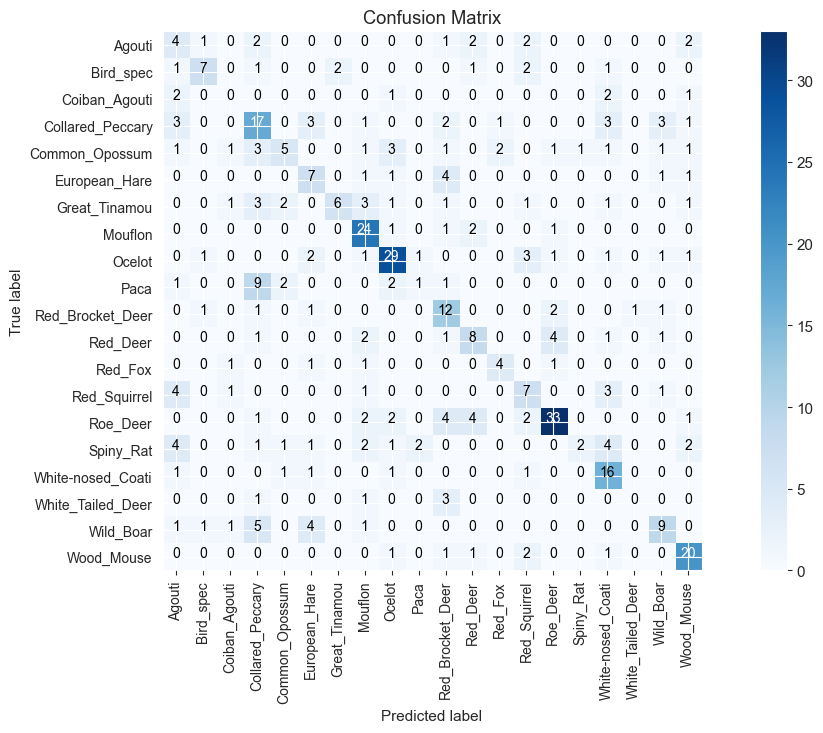

In [65]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [67]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

/var/folders/r0/75rvz7792qg8r39qryvm8b1m0000gn/T/ipykernel_14651/3614164838.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


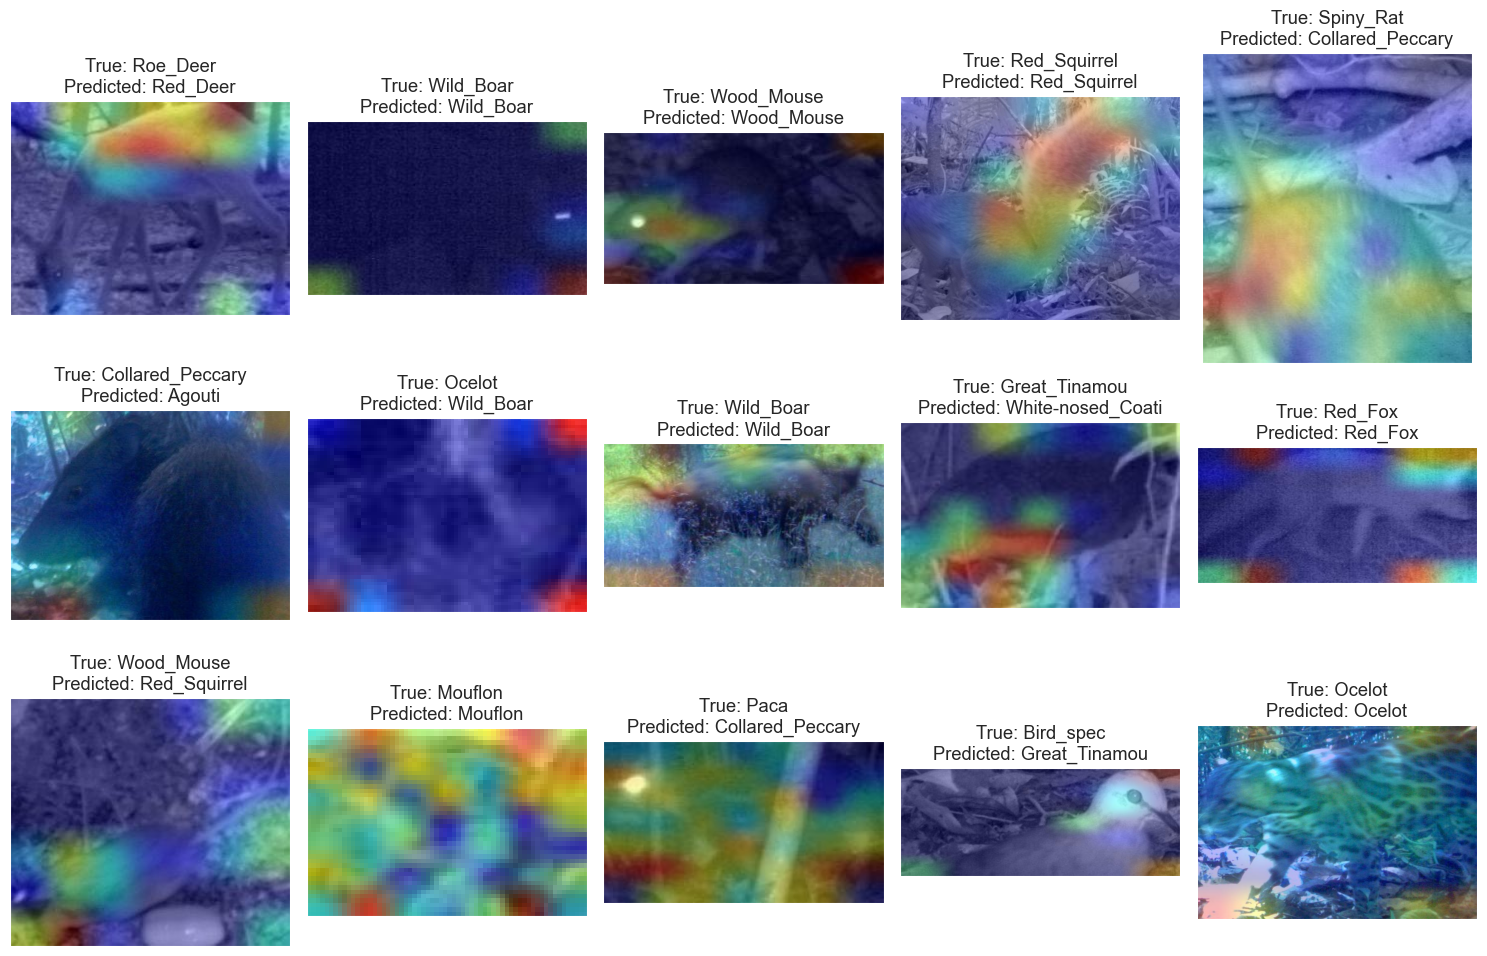

In [68]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()